# Song Lyric Generation Using Pure Next-word Prediction

We define a simple RNN architecture, called `TokenRNN`, to perform pure next-word prediction for religious song lyric generation.

This architecture was adapted from the PyTorch tutorial [NLP From Scratch: Translation with a Sequence to Sequence Network and Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html).

In [ ]:
import os
import sys
import pickle
import torch
import torch.nn
import torch.optim
import torch.utils.data

In [ ]:
"""Google Drive"""
from google.colab import drive
drive.mount('/content/gdrive/')
root_path = '/content/gdrive/My Drive/Virginia Tech/graduate/courses/2021_spring/ece_5424/assignments/project_ece_5424/'
# root_path = '/content/gdrive/My Drive/project_ece_5424/'
dataset_path = './dataset'
store_file = os.path.join(root_path,dataset_path,'lyrics.pickle')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
"""Offline Usage"""
# dataset_path = '../../dataset'
# store_file = os.path.join(dataset_path,'lyrics.pickle')

'Offline Usage'

## Construct Dataset class

We construct a PyTorch dataset class which aids in loading the pre-processed song lyrics.

The pre-processed lyrics come with the following attributes:

- `index2token`: Maps token integer ID to actual token
- `token2index`: Maps token to integer ID
- `counts`: Token frequencies
- `corpus`: List of tokenized lyrics for each sentence
- `vectors`: List of token ID tensors for each sentence

In [ ]:
class WorshipLyricDataset(torch.utils.data.Dataset):
    """Worhip Song dataset from Genius.
    """

    def __init__(self, path: str):

        # Load the pre-processed pickle file.
        with open(path, 'rb') as fp:
            store = pickle.load(fp)
        
        # Unpack the pickle.
        self.index2token = store['index2token']
        self.token2index = store['token2index']
        self.counts = store['counts']
        self.corpus = store['corpus']
        self.vectors = [torch.LongTensor(vec) for vec in store['vectors']]
        self.syllables = torch.nn.functional.one_hot(torch.LongTensor(store['syllables'])) # One-hot encoded syllabl counts.

    def __len__(self):
        return len(self.vectors)

    def __getitem__(self, idx):
        return (self.vectors[idx], self.syllables[idx],)

In [ ]:
# Construct the data object.
dataset = WorshipLyricDataset(path=store_file)

In [ ]:
# Split data into train/validation set.
n_records = len(dataset)
train_len = int(.8 * n_records)
test_len = int(.2 * n_records)
train_subset, test_subset = torch.utils.data.random_split(dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))

To support training with variable-length sentences we must pad the input sentences on a per-batch basis. To do this in conjunction with a data loader, we define a "collate" function which pads the sentences within each batch.

In [ ]:
def pad_collate(batch):
    """Pad batches from dataloader.

    This allows for more efficient padding,
    by only padding within each batch.
    """
    sentences, syllables = zip(*batch)
    sen_lens = torch.LongTensor([len(vec) for vec in sentences])
    sen_pad = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    syllables = torch.stack(syllables) # Convert tuple of tensors to single 2D tensor.
    syllables = syllables.reshape(syllables.size(0),1,syllables.size(1)) # Convert to 3D.
    return (sen_pad,syllables,sen_lens,)

With the dataset and collation function defined we can now construct a `dataloader`, which will allow us to iterate over the lyrics dataset in batches. All training will be done using this loader object.

In [ ]:
# Construct data loader.
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2, collate_fn=pad_collate)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=True, num_workers=2, collate_fn=pad_collate)

## Model - RNN for Pure Next-word Prediction

The anatomy of our model consts of:

1. Embedding input layer
1. Unidirectional single-layer LSTM
1. Fully-connected output layer

The model is generalized to support variable-length sequences by requiring inputs to be **zero-padded** and then it subsequently **packs** the padded input so that padding tokens are ignored by the internal LSTM layers.

For each forward pass of the model it outputs the **current token prediction** (from the fully-connected layer), the **lengths of the sequence predictions** (required for packed padded input sequences), and the **LSTM output hidden and cell states**. This allows the LSTM hidden and cell states to be fed back into subsequent forward passes to retain sequence memory.

In [ ]:
class TokenRNN(torch.nn.Module):
    """Sequence model for token prediction."""
    def __init__(self, n_hidden: int, n_vocab: int, n_layers: int, dropout: float = 0., bidirectional: bool = False):
        super().__init__()

        self.n_hidden = n_hidden
        self.n_vocab = n_vocab
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.n_dir = 2 if bidirectional else 1

        # Embedding layer.
        self.embed = torch.nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=n_hidden,
        )

        # LSTM layer.
        self.lstm = torch.nn.LSTM(
            input_size=n_hidden,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_first=True,
            )

        # Word mapping fully-connected layer.
        self.fc = torch.nn.Linear(in_features=n_hidden, out_features=n_vocab)
    

    def forward(self, sentences: torch.Tensor, lens: torch.Tensor, hidden: torch.Tensor, cell: torch.Tensor):
        """
        Args:
            sentences (torch.Tensor): Sentence word vectors.
            lens (torch.Tensor): True lengths of padded sentence vectors.
            hidden (torch.Tensor): Hidden state vector.
            cell (torch.Tensor): Cell state vector.
        """
        
        # Embed the sentence vectors as floating-point.
        #
        # inputs: (batch_size, sentence_length,)
        sentences_embed = self.embed(sentences)
        # embedded: (batch_size, sentence_length, embed_dim,)

        # Pack the embedding so that the paddings are ignored.
        sentences_embed_packed = torch.nn.utils.rnn.pack_padded_sequence(
            input=sentences_embed,
            lengths=lens, 
            batch_first=True,
            enforce_sorted=False,
            )

        # Pass the input feature vector as the first step.
        output_packed, (hidden, cell) = self.lstm(sentences_embed_packed, (hidden,cell,))

        # Get padded output
        output_padded, output_lens = torch.nn.utils.rnn.pad_packed_sequence(output_packed, batch_first=True)

        # Obtain token-level classification.
        output_padded_fc = self.fc(output_padded)

        # Run packing on output layer.
        return output_padded_fc, output_lens, (hidden, cell,)

    def init_hc(self, batch_size: int, device: str = 'cpu') -> torch.Tensor:
        """Helepr to zero-initialize hidden and cell state tensors."""
        return torch.zeros((self.n_layers*self.n_dir, batch_size, self.n_hidden), device=device)

## Train

Here we define some helper classes and functions for timing the training rounds.

In [ ]:
import time
from contextlib import contextmanager

class timecontext:
    """Elapsed time context manager."""
    def __enter__(self):
        self.seconds = time.time()
        return self
    
    def __exit__(self, type, value, traceback):
        self.seconds = time.time() - self.seconds

@contextmanager
def timecontextprint(description='Elapsed time'):
    """Context manager to print elapsed time from call."""
    with timecontext() as t:
        yield t
    print(f"{description}: {t.seconds} seconds")

The training itself is done by initializing the LSTM hidden and cell states to zero. Then to generalize all sentence structures we always set the first token to be run through the model as the start-of-sentence (SOS) token. 

To better generalize the next-token predictions we apply a technique known as "teacher forcing". In teacher forcing we pass the known next-token target value at each step as the input to the next RNN step. This forces the RNN to learn using the proper next-token rather than solely based on the predictions at each step. To increase generalization performance further we randomly apply teacher forcing for each batch based on a probability distribution (by default 50% probability). 

In [ ]:
import random
from typing import List, Tuple

def train(rnn, train_loader, test_loader, epochs, optimizer, criterion, device='cpu', teacher_force_ratio=0.5) -> Tuple[List[float],List[float]]:
    # Send model to device.
    rnn.to(device)

    # Define loss lists.
    train_loss = []
    test_loss = []

    # Compute batch lengths for averages.
    n_train = len(train_loader)
    n_test = len(test_loader)

    for e in range(epochs):

        # Train model.
        rnn.train()
        running_loss = 0.0
        for b,batch in enumerate(train_loader):
            sentences,_,sen_lens = batch
            sentences = sentences.to(device)
            sen_lens = sen_lens.to(device)

            # Initialize hidden output.
            rnn_hidden = rnn.init_hc(32, device=device)
            rnn_cell = rnn.init_hc(32, device=device)

            # Setup initial rnn inputs.
            SOS_token = dataset.token2index['<sos>']
            rnn_input = SOS_token*torch.ones((sentences.size(0), 1,), dtype=torch.long, device=device)
            rnn_input_lens = torch.ones((sentences.size(0),), dtype=torch.long)

            # Initialize batch loss to zero.
            loss = 0

            # Determine if teacher-forcing should be used for this batch.
            use_teacher_forcing = True if random.random() < teacher_force_ratio else False

            # Teacher forcing.
            # Feed the target as the next input.
            if use_teacher_forcing:
                for target_idx in range(1, sentences.size(1)):
                    outputs, out_lens, (rnn_hidden, rnn_cell) = rnn(rnn_input, rnn_input_lens, rnn_hidden, rnn_cell)

                    # Reshape outputs and targets to fit insize the criterion.
                    outputs = outputs.squeeze(dim=1)
                    targets = sentences[:,target_idx].reshape(sentences.size(0),-1)

                    # Calculate batch loss.
                    loss += criterion(
                        outputs,
                        targets.squeeze(dim=1),
                    )

                    # For teacher forcing set the input of the
                    # next round to be the current target.
                    rnn_input = targets.detach()

            # No teacher forcing.
            # Feed the RNN predictions as the next input.
            else:
                for target_idx in range(1, sentences.size(1)):
                    outputs, out_lens, (rnn_hidden, rnn_cell) = rnn(rnn_input, rnn_input_lens, rnn_hidden, rnn_cell)

                    # Get best prediction.
                    topv, topi = outputs.topk(1)

                    # Reshape outputs and targets to fit insize the criterion.
                    outputs = outputs.squeeze(dim=1)
                    targets = sentences[:,target_idx].reshape(sentences.size(0),-1)

                    # Calculate batch loss.
                    loss += criterion(
                        outputs,
                        targets.squeeze(dim=1),
                    )

                    # Set the input of the next round to be the current prediction.
                    rnn_input = topi.squeeze(dim=-1).detach()

            # Back-propagate, and step the optimizers.
            loss.backward()
            optimizer.step()
            
            # Zero the gradients
            optimizer.zero_grad()

            # Accumulate the loss for this batch.
            running_loss += loss.item()

        # Compute average loss.
        running_loss /= n_train

        # Preserve training loss.
        train_loss.append(running_loss)
        print(f'[epoch {e}]: train loss {running_loss}')

        # ---

        # Validate models.
        rnn.eval()
        with torch.no_grad():
            running_loss = 0.0
            for b,batch in enumerate(test_loader):
                sentences,_,sen_lens = batch
                sentences = sentences.to(device)
                sen_lens = sen_lens.to(device)

                # Initialize hidden output.
                rnn_hidden = rnn.init_hc(32, device=device)
                rnn_cell = rnn.init_hc(32, device=device)

                # Setup initial rnn inputs.
                SOS_token = dataset.token2index['<sos>']
                rnn_input = SOS_token*torch.ones((sentences.size(0), 1,), dtype=torch.long, device=device)
                rnn_input_lens = torch.ones((sentences.size(0),), dtype=torch.long)

                # Initialize batch loss to zero.
                loss = 0

                # Feed prediction as next-input.
                for target_idx in range(1, sentences.size(1)):
                    outputs, out_lens, (rnn_hidden, rnn_cell) = rnn(rnn_input, rnn_input_lens, rnn_hidden, rnn_cell)

                    # Get best prediction.
                    topv, topi = outputs.topk(1)

                    # Reshape outputs and targets to fit insize the criterion.
                    outputs = outputs.squeeze(dim=1)
                    targets = sentences[:,target_idx].reshape(sentences.size(0),-1)

                    # Calculate batch loss.
                    loss += criterion(
                        outputs,
                        targets.squeeze(dim=1),
                    )

                    # Set the input of the next round to be the current prediction.
                    rnn_input = topi.squeeze(dim=-1).detach()
                
                # Accumulate the loss for this batch.
                running_loss += loss.item()

            # Compute average loss.
            running_loss /= n_test

            # Preserve testing loss.
            test_loss.append(running_loss)
            print(f'[epoch {e}]: test loss {running_loss}')


    # Return list of losses for epochs.
    return train_loss, test_loss

In [ ]:
# Length of vocabulary.
n_words = len(dataset.index2token)

# RNN.
rnn = TokenRNN(
    n_vocab=n_words,
    n_hidden=256,
    n_layers=1,
)

To speed-up training PyTorch allows us to leverage a GPU, using CUDA, if one is available. Since training a CNN can be computationally intensive we prefer to use a GPU for speed, but will revert to using the CPU if necessary.

In [ ]:
# Set runtime device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


With the model defined we can now train it on the lyrics dataset.

We define a set of training hyperparameters `epochs` and `lr` which are number of training iterations and optimizer learning rate respectively.

For training we use the `Adam` optimizer and `CrossEntropyLoss` criterion since each next-token prediction is essentially a classification task.

To speed-up subsequent runs, we also save the trained model to a file. This allows us to train the model once, and then simply load the pre-trained model (using the flag `load_from_file = True`) if the Jupyter notebook is run multiple times during a single session.

In [ ]:
import numpy as np

# Define path to RNN model storage.
load_from_file = True
rnn_store = os.path.join(root_path, dataset_path, 'rnn_nsyl.pt')
loss_store = os.path.join(root_path, dataset_path, 'loss_nsyl.npy')

# Load model from store file.
if load_from_file and os.path.exists(rnn_store) and os.path.exists(loss_store):
    print(f'Loading RNN model: {rnn_store}')
    rnn.load_state_dict(torch.load(rnn_store))

    # Read losses from file.
    print(f'Loading RNN losses: {loss_store}')
    with open(loss_store, 'rb') as fp:
       train_loss_rounds, test_loss_rounds = np.load(fp)

else:
    # Learning parameters.
    rounds = 10
    epochs = 10
    lr = 1e-3
    print(f'Training RNN model: rounds={rounds}, epochs={epochs}, lr={lr}, batches={len(train_loader)}')

    # Train the model.
    # Display training time too.
    train_loss_rounds = []
    test_loss_rounds = []
    with timecontextprint():
        optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        for round in range(rounds):
            with timecontextprint(f"[round {round}] elapsed time"):
                train_loss, test_loss = train(rnn,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    epochs=epochs,
                    optimizer=optimizer,
                    criterion=criterion,
                    device=device,
                )
                train_loss_rounds.append(train_loss)
                test_loss_rounds.append(test_loss)

            # Store model state to file.
            torch.save(rnn.state_dict(), rnn_store)
            print(f'[round {round}] saved model: {rnn_store}')

            # Save losses to file too.
            with open(loss_store, 'wb') as fp:
                np.save(fp, [train_loss_rounds, test_loss_rounds])

    train_loss_rounds = np.array(train_loss_rounds) # Convert to numpy array.
    test_loss_rounds = np.array(test_loss_rounds) # Convert to numpy array.

Loading RNN model: /content/gdrive/My Drive/Virginia Tech/graduate/courses/2021_spring/ece_5424/assignments/project_ece_5424/./dataset/rnn_nsyl.pt
Loading RNN losses: /content/gdrive/My Drive/Virginia Tech/graduate/courses/2021_spring/ece_5424/assignments/project_ece_5424/./dataset/loss_nsyl.npy


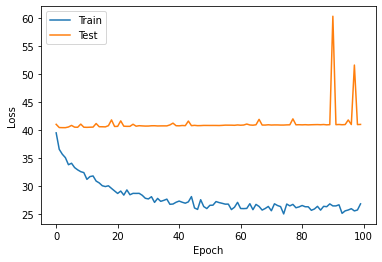

In [ ]:
# Plot the losses
import matplotlib.pyplot as plt
plt.plot(train_loss_rounds.flatten(), label='Train')
plt.plot(test_loss_rounds.flatten(), label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(root_path,dataset_path,'loss_nsyl.png'), dpi=150, bbox_inches='tight')

## Evaluate

Now that the model has been trained we can use it to generate song lyrics.

We define a helper function to evaluate the RNN model. The process of RNN evaluation is actually very similar to training. The difference is that for each token prediction we randomly choose the predicted token based on the normalized probability distribution of the prediction set. We also do not employ teacher forcing since the next-token at each step is unknown.

The evaluation process continuously loops through next-token predictions until either an end-of-sentence (EOS) token or a maximum predicted token length is reached.

In [ ]:
def evaluate(rnn, seed='<sos>', max_length=None, device='cpu') -> List[str]:
    """Generate a sequence of tokens using the TokenRNN and a starting seed."""
    rnn.to(device)
    rnn.eval()
    with torch.no_grad():

        # Initialize hidden output.
        rnn_hidden = rnn.init_hc(1, device=device)
        rnn_cell = rnn.init_hc(1, device=device)

        # Setup initial rnn inputs.
        EOS_index = dataset.token2index['<eos>']
        SOS_index = dataset.token2index['<sos>']
        seed_token = dataset.token2index.get(seed, SOS_index)
        rnn_input = seed_token*torch.ones((1, 1,), dtype=torch.long, device=device)
        rnn_input_lens = torch.ones((1,), dtype=torch.long)

        # Always initialize the deocded tokens with an SOS token.
        tokens = [seed]

        # Loop indefinitely until token list is generated.
        while True:

            # Run current inputs, hidden and cell states through the RNN.
            outputs, out_lens, (rnn_hidden, rnn_cell) = rnn(rnn_input, rnn_input_lens, rnn_hidden, rnn_cell)

            # Normalize the probability distribution of the current prediction.
            probs = np.array(torch.nn.functional.softmax(outputs, dim=2).squeeze().cpu())
            probs = probs / probs.sum()

            # Choose the top prediction from the normalized probability disrtribution above.
            topi = torch.tensor(np.random.choice(rnn.n_vocab, 1, p=probs, replace=False), dtype=torch.long, device=device).view(1,1,1)

            # Add the current token to the predicted token list.
            tokens.append(dataset.index2token[topi.item()])

            # Stop if current token is EOS or maximum sentence length has been reached.
            if (topi.item() == EOS_index) or (max_length and len(tokens) == max_length):
                break

            # Set the input of the next round to be the current prediction.
            rnn_input = topi.squeeze(dim=-1).detach()

        return tokens

We also define a helper function to generate song lyrics, composed of multiple lines, by inputting a set of line-count, optional maximum sentence length, and optional seed list for each sentence. This generates a sequence of tokens for each line of the song and then subsequently joins all lines into a single newline-delimited string.

In [ ]:
def generate_song(num_lines: int, max_length: int = None, seeds: list = None) -> str:
    """Helper to generate song lyrics given constraints."""

    # Build list of line seeds if none were provided.
    seed = '<sos>'
    if not seeds:
        seeds = [seed]*num_lines

    # Generate predictions for each line.
    lines = []
    for i in range(num_lines):
        tokens = evaluate(rnn, max_length=max_length, seed=seeds[i], device=device)
        if tokens[0] != '<sos>': tokens = ['<sos>'] + tokens
        lines.append(' '.join(tokens))

    # Join lines together and return as single string.
    return '\n'.join(lines)

In [ ]:
print(generate_song(num_lines=3, max_length=10))

<sos> my expectation <eos>
<sos> never will never stop never stop working <eos>
<sos> will give you everything say the way <eos>


In [ ]:
print(generate_song(num_lines=3, seeds=['god', 'we', 'they']))

<sos> god bursting healer <eos>
<sos> we deserved no name above every part was so other other name <eos>
<sos> they did not run <eos>


In [ ]:
print(generate_song(num_lines=3, seeds=['we', 'give', 'you',]))

<sos> we worthless travel owe sand <eos>
<sos> give thanks for you <eos>
<sos> you ever take good <eos>


Now let's generate a list of 3-line songs and save them to a file.

In [ ]:
import os
import random

n_songs = 10
num_lines = 3
outfile = os.path.join(root_path, dataset_path, 'gen_lyrics_nonsyl.txt')
overwrite = False
if overwrite or not os.path.exists(outfile):
    with open(outfile, 'w') as fp:
        for n in range(n_songs):
            lyrics = generate_song(num_lines=num_lines)
            fp.write(lyrics + '\n\n')
            print(lyrics + '\n')

Now lets check the accuracy of the sentences. To do this we will compute the Bilingual Evaluation Understudy Score (BLEU). The BLEU is a metric for evaluating a generated sentence w.r.t. a refernce sentence.

In [ ]:
from itertools import zip_longest
def grouper(n, iterable, fillvalue=None):
    """Gleaned from: http://docs.python.org/library/itertools.html#recipes"""
    args = [iter(iterable)]*n
    return zip_longest(fillvalue=fillvalue, *args)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import ast

n_songs = 10
rng = (5, 11) # Random syllable count range
scores = []
with open(outfile, 'r') as fp:
    lines = [l.strip() for l in fp.readlines() if l.strip()]
    for s,tup in enumerate(grouper(3, lines)):
        lyrics = [l.split(' ')[1:] for l in tup] # Split on whitespace and remove "<sos>" token.
        for i,l in enumerate(lyrics):
            cc = SmoothingFunction()
            score = sentence_bleu(dataset.corpus, l, smoothing_function=cc.method4)
            scores.append(score)
            print(f"[song={s}, line={i}] BLEU={score}, sentence={l}")

# Compute total BLEU score across all runs.
total_score = sum(scores)
print(f"Total score: {total_score} BLEU ({len(scores)} candidates)")

[song=0, line=0] BLEU=1.0, sentence=['you', 'to', 'come', 'and', 'have', 'your', 'way', '<eos>']
[song=0, line=1] BLEU=1.0, sentence=['my', 'god', 'is', 'the', 'ancient', 'of', 'days', '<eos>']
[song=0, line=2] BLEU=1.0, sentence=['god', 'there', 'is', 'no', 'one', 'more', 'wonderful', '<eos>']
[song=1, line=0] BLEU=0.43224625083098384, sentence=['over', 'us', '<eos>']
[song=1, line=1] BLEU=0.43224625083098384, sentence=['from', 'bondage', '<eos>']
[song=1, line=2] BLEU=1.0, sentence=['be', 'with', 'you', '<eos>']
[song=2, line=0] BLEU=1.0, sentence=['chain', 'that', 'held', 'me', 'bound', 'is', 'broken', '<eos>']
[song=2, line=1] BLEU=0.7598356856515925, sentence=['beat', 'is', 'yours', 'you', 'can', 'be', 'secure', '<eos>']
[song=2, line=2] BLEU=0.4518010018049224, sentence=['are', '<unk>', 'the', 'ones', 'you', 'love', 'made', '<eos>']
[song=3, line=0] BLEU=1.0, sentence=['if', 'where', 'i', 'tried', 'to', 'go', 'was', 'always', 'here', '<eos>']
[song=3, line=1] BLEU=0.3784810119714